In [4]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas
import montecarlo as mc
import seaborn as sns
import panel as pn
from panel.interact import interact

from iexfinance.stocks import get_historical_data
import iexfinance as iex

In [7]:
mc.iex_search_ticker("VOO")

No database was provided 
Getting data base from IEX...
Succesfully downloaded database.


,currency,date,exchange,iexId,isEnabled,name,region,symbol,type
8338,USD,2019-09-16,PSE,IEX_424D4C325A572D52,True,Vanguard S&P 500 ETF,US,VOO,et
8339,USD,2019-09-16,PSE,IEX_475152374B482D52,True,Vanguard S&P 500 Growth ETF,US,VOOG,et
8340,USD,2019-09-16,PSE,IEX_483958444E302D52,True,Vanguard S&P 500 Value ETF,US,VOOV,et


In [8]:
list_of_tickers = ["VOO"]

In [9]:
portfolio_hist_prices = mc.get_historic_data(ticker = list_of_tickers, 
                                             start_date = datetime.now() + timedelta(-365*5))
portfolio_hist_prices.head()

VOO        
             close  volume
date                      
2014-09-17  184.08  975014
2014-09-18  185.04  740011
2014-09-19  184.86  964014
2014-09-22  182.56  836739
2014-09-23  181.53  752216

In [10]:
btc_daily_price = mc.get_crypto_daily_price(["BTC"],limit=365*5)
btc_daily_price.head()

,BTC
,close
time,
2014-09-18,424.26
2014-09-19,397.67
2014-09-20,411.53
2014-09-21,401.62
2014-09-22,404.09


In [11]:
portfolio_hist_prices = pd.concat([portfolio_hist_prices,btc_daily_price],axis=1,join="inner")
portfolio_hist_prices.dropna(inplace=True)
portfolio_hist_prices.head()

VOO             BTC
             close  volume   close
2014-09-18  185.04  740011  424.26
2014-09-19  184.86  964014  397.67
2014-09-22  182.56  836739  404.09
2014-09-23  181.53  752216  436.86
2014-09-24  182.99  968485  423.77

In [12]:
#Wrap this is in function in the library!!!!!
col_to_drop = portfolio_hist_prices.columns.levels[1].values
col_to_drop = np.delete(col_to_drop,np.where(col_to_drop=="close"))
portfolio_daily_retn = portfolio_hist_prices.drop(columns=col_to_drop, level=1).copy()
portfolio_daily_retn.columns = portfolio_daily_retn.columns.droplevel(1)
portfolio_daily_retn = portfolio_daily_retn.pct_change()

portfolio_daily_retn

,VOO,BTC
2014-09-18,NaN,NaN
2014-09-19,-0.000973,-0.062674
2014-09-22,-0.012442,0.016144
2014-09-23,-0.005642,0.081096
2014-09-24,0.008043,-0.029964
2014-09-25,-0.016066,-0.027090
2014-09-26,0.008053,-0.018991
2014-09-29,-0.001983,-0.068462
2014-09-30,-0.003036,0.030257
2014-10-01,-0.013124,-0.013731


In [23]:
def corr_plot(portfolio_daily_retn):
    correlated = portfolio_daily_retn.corr()
    #correlated
    #A failed attemp to use hvplot to create a heatmap. Worthy of more research.
    #correlated_plot = correlated.hvplot.heatmap(x = correlated.index.values, y = correlated.columns.values)
    #correlated_plot #didn't work. It would be cool to find another way.
    # Generate a mask for the upper triangle
    mask = np.zeros_like(correlated, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    correlated_plot, ax = plt.subplots(figsize=(6, 4))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlated, mask=mask, cmap="coolwarm", vmax=1, vmin =-1, center=0,
                square=True, linewidths=.5, annot=True
                #cbar_kws={"shrink": .5}
               )
    
    #correlated_plot = sns.heatmap(correlated, vmin=-1, vmax=1, annot=True,cmap="coolwarm") 
    plt.close()
    return pn.Pane(correlated_plot)

In [14]:
def sharp_rt_plot(portfolio_daily_retn):
    
    sharp_ratios = portfolio_daily_retn.mean()*np.sqrt(252)/portfolio_daily_retn.std()
    
    #with hvplot(): 
    #sr_plot = sharp_ratios.hvplot.bar()
    
    sr_plot = plt.figure();
    plt.bar(x = sharp_ratios.index, height=sharp_ratios)
    plt.axhline(sharp_ratios.mean(), color='r')
    #plt.ylim(sharp_ratios.min()*0.997,sharp_ratios.max()*1.002)
    plt.close()
    return sr_plot

In [15]:

monte_carlo_sim = mc.monte_carlo_sim(df=portfolio_hist_prices, trials=10, sim_days=252)

def plot_mont_carl(monte_carlo_sim):
    plot_title = f"title"
    monte_carlo_sim_plot = monte_carlo_sim.hvplot(title=plot_title,figsize=(18,10))
    return monte_carlo_sim_plot

In [16]:
def get_conf_interval(db,q=[0.05, 0.95]):
    confidence_interval = db.iloc[-1].quantile(q=q)
    return confidence_interval

In [18]:
def plot_conf(values=monte_carlo_sim.iloc[-1],conf=[0,0]):
    conifidence_plot = plt.figure();
    #plt.plot(values,kind='hist', density=True, bins=20)
    plt.hist(x = values,bins=20)
    plt.axvline(conf.iloc[0], color='r')
    plt.axvline(conf.iloc[1], color='r')
    plt.close()
    return pn.Pane(conifidence_plot)

# DASHBOARD TIME!!!

In [21]:
mc_sim = mc.monte_carlo_sim(portfolio_hist_prices,trials = 100)

In [24]:
risk_tabs = pn.Tabs(
    ("Correlation of portfolio",corr_plot(portfolio_daily_retn)),
    ("Sharp Ratios", sharp_rt_plot(portfolio_daily_retn))
)

In [21]:
montecarlo_tabs = pn.Tabs(
    ("monte Carlo Simulation",plot_mont_carl(mc_sim)),
    ("Confidence Intervals", plot_conf(mc_sim.iloc[-1],get_conf_interval(mc_sim)))
)

In [21]:
techl_analysis_tabs = pn.Tabs(
    ("TA1","in construction"),
    ("TA2", "in construction")
)

In [25]:
tabs = pn.Tabs(
    ("Risk",risk_tabs),
    ("Monte Carlo Simulation", montecarlo_tabs),
    ("Tecnical Analysis", techl_analysis_tabs),
    ("Report", "in construction")
)
  

Tabs
    [0] Tabs
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure, name='Sharp Ratios')
    [1] Tabs(active=1)
        [0] HoloViews(NdOverlay, name='monte Carlo Simulation')
        [1] Matplotlib(Figure)
    [2] Tabs
        [0] Markdown(str, name='TA1')
        [1] Markdown(str, name='TA2')
    [3] Markdown(str, name='Report')
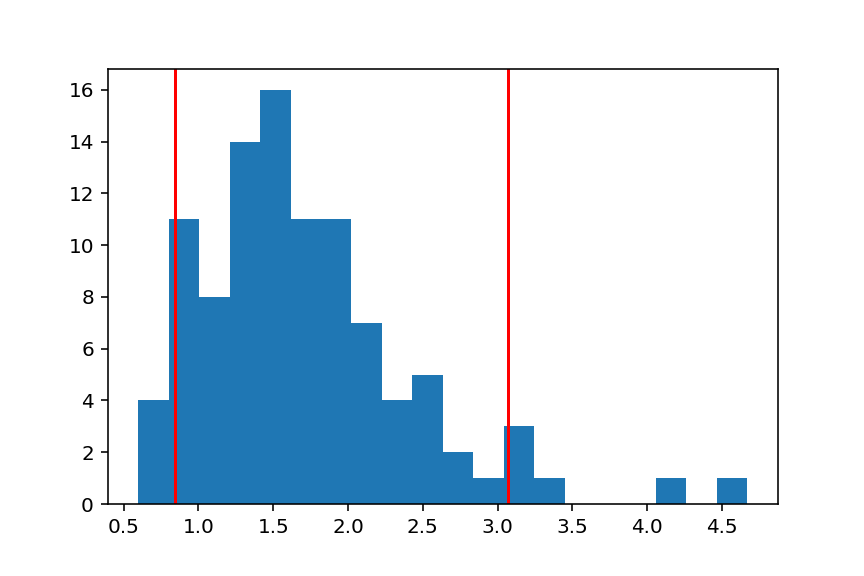
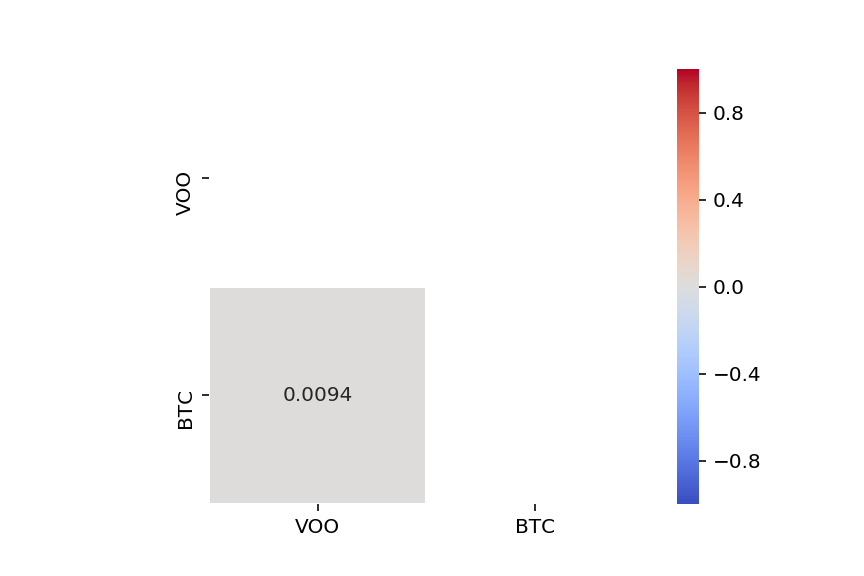
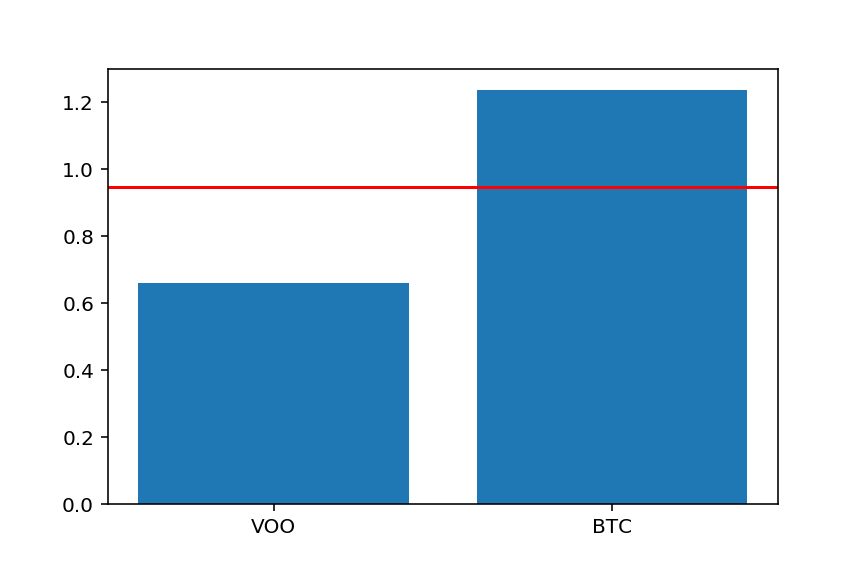

In [26]:
  
panel = tabs

panel

In [2]:
btc_daily_price = mc.get_crypto_daily_price(["BTC"])

In [3]:
btc_daily_price

,BTC
,close
time,
2019-06-19,9280.54
2019-06-20,9536.85
2019-06-21,10218.87
2019-06-22,10689.54
2019-06-23,10855.99
2019-06-24,11035.74
2019-06-25,11740.34
2019-06-26,12913.28


In [22]:
portfolio_hist_prices.head(21)

VOO              BTC
             close   volume   close
2014-09-18  185.04   740011  424.26
2014-09-19  184.86   964014  397.67
2014-09-22  182.56   836739  404.09
2014-09-23  181.53   752216  436.86
2014-09-24  182.99   968485  423.77
2014-09-25  180.05  1602998  412.29
2014-09-26  181.50   916883  404.46
2014-09-29  181.14  1482872  376.77
2014-09-30  180.59   768165  388.17
2014-10-01  178.22  2380285  382.84
2014-10-02  178.21  1263791  375.14
2014-10-03  180.20  1217407  363.45
2014-10-06  179.98  1306964  331.55
2014-10-07  177.22   930808  331.65
2014-10-08  180.32  1896644  350.87
2014-10-09  176.68  1428571  360.91
2014-10-10  174.70  2470001  361.71
2014-10-13  171.83  2109202  387.32
2014-10-14  172.11  2431931  397.10
2014-10-15  170.83  5460588  393.17
2014-10-16  170.72  4452628  379.77